In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns
from scipy import stats

from statsmodels.stats import multitest
import ptitprince as pt
import copy

In [3]:
import popoff
import pop_off_plotting as pop
from pop_off_plotting import color_tt
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel

/home/tplas/repos/popping-off/popoff/popoff/loadpaths.py
/home/tplas/repos/Vape


In [4]:
msm = MultiSessionModel(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True)

long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time




s1
Hit vs Miss, p = 0.0009765625, significant = True
Hit vs CR, p = 0.0009765625, significant = True
Hit vs FP, p = 0.0009765625, significant = True
Hit vs Reward
only, p = 0.0009765625, significant = True


s2
Hit vs Miss, p = 0.0322265625, significant = False
Hit vs CR, p = 0.001953125, significant = True
Hit vs FP, p = 0.0322265625, significant = False
Hit vs Reward
only, p = 0.0009765625, significant = True


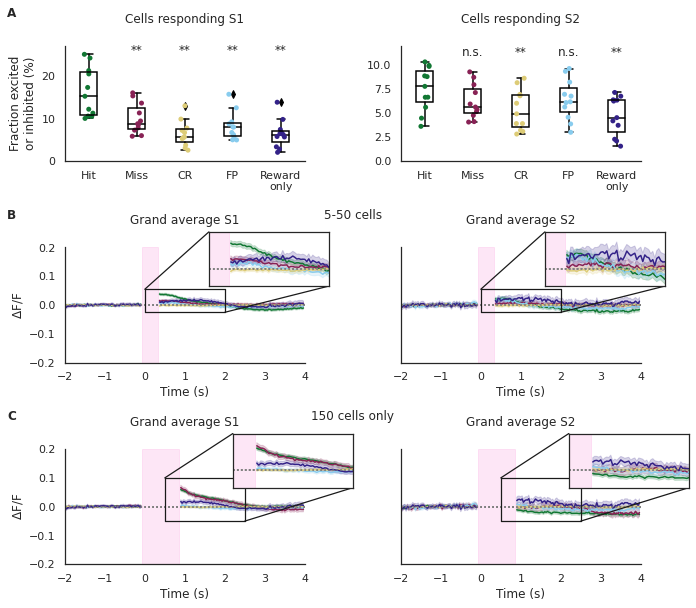

In [17]:
fig = plt.figure(constrained_layout=False, figsize=(8, 8))
save_fig = True

tts = ['hit', 'miss', 'fp', 'cr', 'pre_reward']

rains = fig.add_gridspec(ncols=2, nrows=1, bottom=0.8, top=1, right=1, left=0,
                            wspace=0.4, hspace=0.85)
without_150 = fig.add_gridspec(ncols=2, nrows=1, bottom=0.45, top=0.65, right=1, left=0,
                               wspace=0.4, hspace=0.85)
only_150 = fig.add_gridspec(ncols=2, nrows=1, bottom=0.1, top=0.3, right=1, left=0,
                            wspace=0.4, hspace=0.85)

fig.text(0.5, 0.7, '5-50 cells', ha="center")
fig.text(0.5, 0.35, '150 cells only', ha="center")

ax_pop_activity_wo = {xx: fig.add_subplot(without_150[xx]) for xx in range(2)}

for n_cells in [[5, 10, 20, 30, 40, 50]]:
    tmp = pop.plot_average_tt_s1_s2(msm, n_cells, tts_plot=tts,
                                   ax_s1=ax_pop_activity_wo[0], ax_s2=ax_pop_activity_wo[1],
                                   plot_legend=(n_cells == 50))
    
ax_pop_activity_wo[0].set_title('Grand average S1', y=1.15)
ax_pop_activity_wo[1].set_title('Grand average S2', y=1.15)
    
ax_pop_activity_150 = {xx: fig.add_subplot(only_150[xx]) for xx in range(2)}

for n_cells in [[150]]:
    tmp = pop.plot_average_tt_s1_s2(msm, n_cells, tts_plot=tts,
                                   ax_s1=ax_pop_activity_150[0], ax_s2=ax_pop_activity_150[1],
                                   plot_legend=False, zoom_ylims=(-0.05, 0.1))
    
ax_pop_activity_150[0].set_title('Grand average S1', y=1.15)
ax_pop_activity_150[1].set_title('Grand average S2', y=1.15)

ax_rains = [fig.add_subplot(rains[xx]) for xx in range(2)]
pop.despine(ax_rains[0])
pop.despine(ax_rains[1])

pop.percent_responding_tts(lm_list=msm.linear_models, axes=ax_rains)

ax_rains[0].set_title('Cells responding S1', y=1.15)
ax_rains[1].set_title('Cells responding S2', y=1.15)

fig.text(s='A', x=-0.1, y=1.05, fontdict={'weight': 'bold'})
fig.text(s='B', x=-0.1, y=0.7, fontdict={'weight': 'bold'})
fig.text(s='C', x=-0.1, y=0.35, fontdict={'weight': 'bold'})

if save_fig:
    plt.savefig('/home/tplas/repos/popping-off/figures/full_figs_manuscript/Supplementary_Figure1.pdf',
                bbox_inches='tight')